In [1]:
from datetime import datetime
import pathlib as pl
import re

import pandas as pd

from pyprojroot import here

In [2]:
def color_pos(val):
    color = 'red' if val is True else 'black'
    return 'color: %s' % color

In [3]:
kw_metadata_df = pd.read_pickle(here("./data/db/working/kaggle/id_model_inputs/02-kw_w_metadata.pickle"))

In [4]:
kw_metadata_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33503 entries, 0 to 33502
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   pid                         33503 non-null  object 
 1   title_x                     33503 non-null  object 
 2   has-incubation_period       33503 non-null  bool   
 3   has-infectiousness_period   33503 non-null  bool   
 4   has-recovery_rate           33503 non-null  bool   
 5   has-case_fatality_ratio     33503 non-null  bool   
 6   has-asymptomatic_fraction   33503 non-null  bool   
 7   has-hospitalized_fraction   33503 non-null  bool   
 8   text_sent                   33503 non-null  object 
 9   sent-incubation_period_day  33503 non-null  object 
 10  sent-infectiousness_period  33503 non-null  object 
 11  sent-recovery_rate          33503 non-null  object 
 12  sent-case_fatality_ratio    33503 non-null  object 
 13  sent-asymptomatic_fraction  335

## Filter on any sentence matches

papers that have at least 1 keyword match

In [5]:
kw_metadata_df['any_has'] = kw_metadata_df.filter(like="has-").apply(any, axis=1)
kw_metadata_df['any_sent'] = kw_metadata_df.filter(like="sent-").astype(bool).apply(any, axis=1)

In [6]:
# any_sent looks at "incubation period day" while any has only looks at "incubation period"
pd.crosstab(kw_metadata_df['any_has'], kw_metadata_df['any_sent'], margins=True)

any_sent,False,True,All
any_has,,,
False,30610,0,30610
True,1127,1766,2893
All,31737,1766,33503


In [7]:
kw_metadata_df[(kw_metadata_df['any_sent'] == False) & (kw_metadata_df['any_has'] == True)].filter(regex='has-|sent-')

,has-incubation_period,has-infectiousness_period,has-recovery_rate,has-case_fatality_ratio,has-asymptomatic_fraction,has-hospitalized_fraction,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
7,True,False,False,False,False,False,[],[],[],[],[],[]
72,True,False,False,False,False,False,[],[],[],[],[],[]
100,True,False,False,False,False,False,[],[],[],[],[],[]
110,True,False,False,False,False,False,[],[],[],[],[],[]
159,True,False,False,False,False,False,[],[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...,...
33105,True,False,False,False,False,False,[],[],[],[],[],[]
33313,True,False,False,False,False,False,[],[],[],[],[],[]
33367,True,False,False,False,False,False,[],[],[],[],[],[]
33413,True,False,False,False,False,False,[],[],[],[],[],[]


In [8]:
sent_kw_metadata_df = kw_metadata_df[(kw_metadata_df['any_sent'] == True)]
sent_kw_metadata_df.shape

(1766, 35)

In [9]:
len(sent_kw_metadata_df)

1766

## Search for specific papers

In [10]:
covid_papers = [
    "PMC7121484", # Early Transmission Dynamics in Wuhan
    "PMC7186508" # To mask or not to mask
]
kw_metadata_df[kw_metadata_df.pid.isin(covid_papers)].filter(like="sent-")

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
22562,[We examined data on exposures among 10 confir...,[],[],[],[],[]
32564,[],[],"[Additionally, η accounts for the relative inf...",[],[],[We find that a small delay in mask adoption (...


## Which papers contain which KWs

In [11]:
sent_cols = sent_kw_metadata_df.columns[sent_kw_metadata_df.columns.str.contains("sent-")]
sent_cols

Index(['sent-incubation_period_day', 'sent-infectiousness_period',
       'sent-recovery_rate', 'sent-case_fatality_ratio',
       'sent-asymptomatic_fraction', 'sent-hospitalized_fraction'],
      dtype='object')

In [12]:
sent_bool = sent_kw_metadata_df[sent_cols].astype(bool)
sent_bool

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
52,True,False,False,False,False,False
61,True,False,False,False,False,False
75,False,False,False,True,False,False
107,True,False,False,False,False,False
166,True,False,False,False,False,False
...,...,...,...,...,...,...
33349,False,False,True,False,False,False
33362,False,False,True,False,False,False
33429,False,False,False,True,False,False
33497,True,False,False,False,False,False


In [13]:
sent_bool['num_matches'] = sent_bool.apply(sum, axis=1)

In [14]:
sent_bool['num_matches'].value_counts()

1    1696
2      66
3       4
Name: num_matches, dtype: int64

In [15]:
num_sent_matches = sent_bool.apply(sum, axis=1).value_counts(dropna=False)
num_sent_matches

2    1696
4      66
6       4
dtype: int64

In [16]:
len(sent_bool)

1766

In [17]:
num_sent_matches.sum()

1766

In [18]:
counts = sent_bool.groupby(list(sent_cols))['num_matches'].sum()

In [19]:
count_df = pd.DataFrame(counts, dtype=int)
count_df.columns = ["count"]
count_df = count_df.reset_index()
count_df['contain_ct'] = count_df.filter(like='sent-').apply(sum, axis=1)

In [20]:
counts = count_df.sort_values(by=["count"], ascending=False)
counts.style.applymap(color_pos)

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction,count,contain_ct
8,True,False,False,False,False,False,1274,1
2,False,False,True,False,False,False,326,1
1,False,False,False,True,False,False,92,1
10,True,False,True,False,False,False,62,2
9,True,False,False,True,False,False,56,2
11,True,False,True,True,False,False,9,3
4,False,False,True,True,False,False,4,2
12,True,True,False,False,False,False,4,2
13,True,True,False,True,False,False,3,3
0,False,False,False,False,True,False,2,1


In [21]:
count_df.sort_values(['contain_ct'] + sent_cols.tolist()).style.applymap(color_pos)

,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction,count,contain_ct
0,False,False,False,False,True,False,2,1
1,False,False,False,True,False,False,92,1
2,False,False,True,False,False,False,326,1
5,False,True,False,False,False,False,2,1
8,True,False,False,False,False,False,1274,1
3,False,False,True,False,False,True,2,2
4,False,False,True,True,False,False,4,2
6,False,True,False,True,False,False,2,2
7,False,True,True,False,False,False,2,2
9,True,False,False,True,False,False,56,2


In [22]:
1840-1766

74

In [23]:
counts["count"].sum()

1840

In [24]:
len(sent_kw_metadata_df.pid.unique())

1766

In [25]:
sent_long = sent_kw_metadata_df.filter(regex="pid|sent-").melt(id_vars='pid')
sent_long

,pid,variable,value
0,PMC1247620,sent-incubation_period_day,"[A 5-day incubation period, consistent with a ..."
1,PMC1262710,sent-incubation_period_day,"[After an incubation period from 2 to 10 days,..."
2,PMC1298938,sent-incubation_period_day,[]
3,PMC1435713,sent-incubation_period_day,[The mathematical model can be thought of as a...
4,PMC1562405,sent-incubation_period_day,[Information was collected regarding the parti...
...,...,...,...
10591,PMC7200323,sent-hospitalized_fraction,[]
10592,PMC7200851,sent-hospitalized_fraction,[]
10593,PMC7202125,sent-hospitalized_fraction,[]
10594,PMC7204583,sent-hospitalized_fraction,[]


In [26]:
sent_long.loc[sent_long['value'].astype(bool)].pid.duplicated().sum()

74

## Filter on date

In [27]:
sent_kw_metadata_df.shape

(1766, 35)

In [28]:
len(sent_kw_metadata_df)

1766

In [29]:
sent_kw_metadata_df["publish_time_dt"] = pd.to_datetime(sent_kw_metadata_df["publish_time"], yearfirst=True)

earliest_date = pd.to_datetime("2019-06-01", yearfirst=True)
earliest_date

<ipython-input-29-38ab7d59dc5e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sent_kw_metadata_df["publish_time_dt"] = pd.to_datetime(sent_kw_metadata_df["publish_time"], yearfirst=True)


Timestamp('2019-06-01 00:00:00')

In [30]:
kw_dt_filtered = sent_kw_metadata_df[(sent_kw_metadata_df["publish_time_dt"] >= earliest_date) & 
                                     (sent_kw_metadata_df["publish_time_dt"] <= pd.to_datetime("today")) # some dates are after today...
                                     ]
kw_dt_filtered.shape

(325, 36)

In [31]:
print(f"number of unique pid's since {earliest_date}: {kw_dt_filtered.pid.unique().shape}")

number of unique pid's since 2019-06-01 00:00:00: (325,)


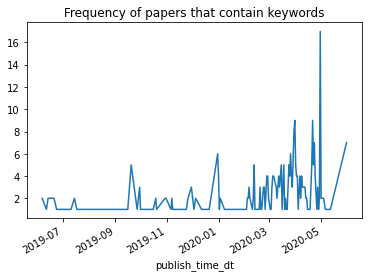

In [32]:
(kw_dt_filtered
 .groupby(["publish_time_dt"])
 .size()
 .sort_index()
 .plot(title="Frequency of papers that contain keywords")
)

#### These are dates that will be problematic in the future

In [33]:
len(sent_kw_metadata_df)

1766

In [34]:
future_dates_df = (sent_kw_metadata_df
                   [(sent_kw_metadata_df["publish_time_dt"] > pd.to_datetime("today"))]
                   [["pid", "publish_time_dt", "title_x", "journal", "url", "doi"]]
                   .sort_values("publish_time_dt")
                   .reset_index(drop=True)
                  )

future_dates_df.shape

(17, 6)

In [35]:
with pd.option_context('display.min_rows', len(future_dates_df), 'display.max_columns', None, 'display.max_colwidth', -1):
    display(future_dates_df)

,pid,publish_time_dt,title_x,journal,url,doi
0,PMC7118632,2020-06-07,True epidemic growth construction through harmonic analysis,Journal of Theoretical Biology,NaN,10.1016/j.jtbi.2020.110243
1,PMC7151535,2020-06-15,Central nervous system manifestations of COVID-19: A systematic review,J Neurol Sci,NaN,10.1016/j.jns.2020.116832
2,PMC7198143,2020-06-30,Pediatric and Adolescent Gynecology (PAG) in the Time of a Pandemic,Journal of Pediatric and Adolescent Gynecology,NaN,10.1016/j.jpag.2020.03.002
3,PMC7195311,2020-06-30,Epidemiology and clinical features of COVID-19: A review of current literature,Journal of Clinical Virology,NaN,10.1016/j.jcv.2020.104357
4,PMC7194884,2020-06-30,"Clinical features and short-term outcomes of 221 patients with COVID-19 in Wuhan, China",Journal of Clinical Virology,NaN,10.1016/j.jcv.2020.104364
5,PMC7165099,2020-06-30,Chest CT findings of COVID-19 pneumonia by duration of symptoms,European Journal of Radiology,NaN,10.1016/j.ejrad.2020.109009
6,PMC7195434,2020-06-30,Prevalence and severity of corona virus disease 2019 (COVID-19): A systematic review and meta-analysis,Journal of Clinical Virology,NaN,10.1016/j.jcv.2020.104371
7,PMC7194845,2020-07-01,In silico studies on therapeutic agents for COVID-19: Drug repurposing approach,Life Sci,NaN,10.1016/j.lfs.2020.117652
8,PMC7111840,2020-07-01,EuNPs-mAb fluorescent probe based immunochromatographic strip for rapid and sensitive detection of porcine epidemic diarrhea virus,Talanta,NaN,10.1016/j.talanta.2020.120865
9,PMC7142675,2020-07-01,Association between ambient temperature and COVID-19 infection in 122 cities from China,Sci Total Environ,NaN,10.1016/j.scitotenv.2020.138201


## Filter on covid19 related terms

In [36]:
covid_papers

['PMC7121484', 'PMC7186508']

In [37]:
kw_dt_filtered[kw_dt_filtered.pid.isin(covid_papers)]

,pid,title_x,has-incubation_period,has-infectiousness_period,has-recovery_rate,has-case_fatality_ratio,has-asymptomatic_fraction,has-hospitalized_fraction,text_sent,sent-incubation_period_day,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,any_has,any_sent,publish_time_dt
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",True,False,False,False,False,False,[The earliest cases were identified through th...,[We examined data on exposures among 10 confir...,...,N Engl J Med,NaN,#57,NaN,document_parses/pdf_json/e65a594a2d8b64fc8fccf...,document_parses/pmc_json/PMC7121484.xml.json,NaN,True,True,2020-03-26
32564,PMC7186508,To mask or not to mask: Modeling the potential...,True,False,True,False,False,True,[Under the ongoing COVID-19 pandemic (caused b...,[],...,Infect Dis Model,NaN,NaN,2004.03251,document_parses/pdf_json/dfc39cdae5551d6856865...,document_parses/pmc_json/PMC7186508.xml.json,NaN,True,True,2020-04-21


In [38]:
kw_dt_filtered[kw_dt_filtered.pid.isin(covid_papers)].text_sent.str.get(0)

22562    The earliest cases were identified through the...
32564    Under the ongoing COVID-19 pandemic (caused by...
Name: text_sent, dtype: object

In [39]:
filter_words_lower_regex = [
    r".*covid\s?-?\s?19.*", # covid-19
    r".*sars-?cov-?2.*",    # sars-cov-2
    r".*ncov.*",            # ncov
    r".*coronavirus.*",     # coronavirus
]
pattern = "|".join(filter_words_lower_regex)
pattern

'.*covid\\s?-?\\s?19.*|.*sars-?cov-?2.*|.*ncov.*|.*coronavirus.*'

In [40]:
r = re.compile(pattern)
r

re.compile(r'.*covid\s?-?\s?19.*|.*sars-?cov-?2.*|.*ncov.*|.*coronavirus.*',
re.UNICODE)

In [41]:
kw_dt_filtered.shape

(325, 36)

In [42]:
kw_dt_filtered.columns

Index(['pid', 'title_x', 'has-incubation_period', 'has-infectiousness_period',
       'has-recovery_rate', 'has-case_fatality_ratio',
       'has-asymptomatic_fraction', 'has-hospitalized_fraction', 'text_sent',
       'sent-incubation_period_day', 'sent-infectiousness_period',
       'sent-recovery_rate', 'sent-case_fatality_ratio',
       'sent-asymptomatic_fraction', 'sent-hospitalized_fraction', 'cord_uid',
       'sha', 'source_x', 'title_y', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 'any_has', 'any_sent', 'publish_time_dt'],
      dtype='object')

In [43]:
matched_papers = []
for pidx, paper_text in enumerate(kw_dt_filtered.text_sent):
    for sidx, sentence in enumerate(paper_text):
        if r.match(sentence.lower()):
            #print(f"paper: {pidx}, sentence: {sidx}")
            matched_papers.append(kw_dt_filtered.iloc[pidx])
            break

In [44]:
len(matched_papers)

289

In [45]:
# look for pattern matches all lower case
has_covid_term = kw_dt_filtered['text_sent'].apply(lambda x: any([True for sent in x if r.match(sent.lower())]))

In [46]:
covid_kw_sent = kw_dt_filtered[has_covid_term]

In [47]:
covid_kw_sent.shape

(289, 36)

In [48]:
covid_kw_sent[covid_kw_sent.pid.isin(covid_papers)]

,pid,title_x,has-incubation_period,has-infectiousness_period,has-recovery_rate,has-case_fatality_ratio,has-asymptomatic_fraction,has-hospitalized_fraction,text_sent,sent-incubation_period_day,...,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,any_has,any_sent,publish_time_dt
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",True,False,False,False,False,False,[The earliest cases were identified through th...,[We examined data on exposures among 10 confir...,...,N Engl J Med,NaN,#57,NaN,document_parses/pdf_json/e65a594a2d8b64fc8fccf...,document_parses/pmc_json/PMC7121484.xml.json,NaN,True,True,2020-03-26
32564,PMC7186508,To mask or not to mask: Modeling the potential...,True,False,True,False,False,True,[Under the ongoing COVID-19 pandemic (caused b...,[],...,Infect Dis Model,NaN,NaN,2004.03251,document_parses/pdf_json/dfc39cdae5551d6856865...,document_parses/pmc_json/PMC7186508.xml.json,NaN,True,True,2020-04-21


In [49]:
covid_kw_sent[covid_kw_sent.pid.isin(covid_papers)].filter(like="sent-incu").iloc[0][0]

['We examined data on exposures among 10 confirmed cases, and we estimated the mean incubation period to be 5.2 days (95% confidence interval [CI], 4.1 to 7.0); the 95th percentile of the distribution was 12.5 days (95% CI, 9.2 to 18) (Figure 2A).',
 'Our preliminary estimate of the incubation period distribution provides important evidence to support a 14-day medical observation period or quarantine for exposed persons.']

## Explode sentences

In [50]:
covid_kw_sent.pid.duplicated().any()

False

In [51]:
sent_cols.to_list()

['sent-incubation_period_day',
 'sent-infectiousness_period',
 'sent-recovery_rate',
 'sent-case_fatality_ratio',
 'sent-asymptomatic_fraction',
 'sent-hospitalized_fraction']

In [52]:
covid_kw_sent.columns

Index(['pid', 'title_x', 'has-incubation_period', 'has-infectiousness_period',
       'has-recovery_rate', 'has-case_fatality_ratio',
       'has-asymptomatic_fraction', 'has-hospitalized_fraction', 'text_sent',
       'sent-incubation_period_day', 'sent-infectiousness_period',
       'sent-recovery_rate', 'sent-case_fatality_ratio',
       'sent-asymptomatic_fraction', 'sent-hospitalized_fraction', 'cord_uid',
       'sha', 'source_x', 'title_y', 'doi', 'pmcid', 'pubmed_id', 'license',
       'abstract', 'publish_time', 'authors', 'journal', 'mag_id',
       'who_covidence_id', 'arxiv_id', 'pdf_json_files', 'pmc_json_files',
       'url', 'any_has', 'any_sent', 'publish_time_dt'],
      dtype='object')

In [53]:
non_sent_cols = ["pid", "title", "publish_time_dt", 'doi', 'url']
non_sent_cols

['pid', 'title', 'publish_time_dt', 'doi', 'url']

In [54]:
covid_kw_sent_subset = covid_kw_sent.rename(columns={"title_x": "title"})[non_sent_cols + sent_cols.to_list()]
covid_kw_sent_subset

,pid,title,publish_time_dt,doi,url,sent-incubation_period_day,sent-infectiousness_period,sent-recovery_rate,sent-case_fatality_ratio,sent-asymptomatic_fraction,sent-hospitalized_fraction
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,[],[],[],"[gender, age, occupation [7,100,101]), case fa...",[],[]
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,[Given an average incubation period of 12 days...,[],[],[],[],[]
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,[The end date was achieved after 28 days witho...,[],[],[],[],[]
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,[],[],[Zinc supplementation in children decreases th...,[],[],[]
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,[The protozoan infection occurred prior to the...,[],[],[],[],[]
...,...,...,...,...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[],[],[The recovery rate increased by more than 10% ...,[],[],[]
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[],[],[We obtained the data regarding total daily be...,[],[],[]
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[],[],[],"[7,8\nCase fatality ratios range widely from 0...",[],[]
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,[The incubation period of the presented case w...,[],[],[],[],[]


In [55]:
exploded_df_list = []

for idx, sc in enumerate(sent_cols):
    print(idx, sc)
    exploded = covid_kw_sent_subset[non_sent_cols + [sc]].explode(sc)
    exploded = exploded.rename({sc: "sentence"}, axis='columns')
    exploded['match_type'] = sc
    display(exploded)
    exploded_df_list.append(exploded)

0 sent-incubation_period_day


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-incubation_period_day
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Given an average incubation period of 12 days ...,sent-incubation_period_day
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Responding more than 20 days from the virus re...,sent-incubation_period_day
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,The end date was achieved after 28 days withou...,sent-incubation_period_day
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-incubation_period_day
...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-incubation_period_day
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-incubation_period_day
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-incubation_period_day
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The incubation period of the presented case wa...,sent-incubation_period_day


1 sent-infectiousness_period


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-infectiousness_period
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-infectiousness_period
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,NaN,sent-infectiousness_period
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-infectiousness_period
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-infectiousness_period
...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-infectiousness_period
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-infectiousness_period
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-infectiousness_period
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-infectiousness_period


2 sent-recovery_rate


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-recovery_rate
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-recovery_rate
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,NaN,sent-recovery_rate
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Zinc supplementation in children decreases the...,sent-recovery_rate
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-recovery_rate
...,...,...,...,...,...,...,...
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,We obtained the data regarding total daily bed...,sent-recovery_rate
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The overall recovery rate was positive correla...,sent-recovery_rate
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-recovery_rate
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-recovery_rate


3 sent-case_fatality_ratio


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"gender, age, occupation [7,100,101]), case fat...",sent-case_fatality_ratio
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-case_fatality_ratio
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,NaN,sent-case_fatality_ratio
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-case_fatality_ratio
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-case_fatality_ratio
...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-case_fatality_ratio
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-case_fatality_ratio
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"7,8\nCase fatality ratios range widely from 0....",sent-case_fatality_ratio
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-case_fatality_ratio


4 sent-asymptomatic_fraction


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-asymptomatic_fraction
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-asymptomatic_fraction
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,NaN,sent-asymptomatic_fraction
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-asymptomatic_fraction
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-asymptomatic_fraction
...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-asymptomatic_fraction
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-asymptomatic_fraction
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-asymptomatic_fraction
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-asymptomatic_fraction


5 sent-hospitalized_fraction


,pid,title,publish_time_dt,doi,url,sentence,match_type
12407,PMC6558557,Outbreak analytics: a developing data science ...,2019-07-08,10.1098/rstb.2018.0276,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-hospitalized_fraction
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-hospitalized_fraction
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,NaN,sent-hospitalized_fraction
12563,PMC6619766,Effectiveness of zinc supplementation on diarr...,2019-07-10,10.1371/journal.pone.0219321,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-hospitalized_fraction
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,NaN,sent-hospitalized_fraction
...,...,...,...,...,...,...,...
33349,PMC7200323,Modeling the trend of coronavirus disease 2019...,2020-05-06,10.1186/s41256-020-00145-4,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-hospitalized_fraction
33362,PMC7200851,Critical role of Wuhan cabin hospitals in cont...,2020-04-22,10.1017/ice.2020.167,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-hospitalized_fraction
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-hospitalized_fraction
33497,PMC7204583,Case Report: Walking Pneumonia in Novel Corona...,2020-04-01,10.4269/ajtmh.20-0203,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,NaN,sent-hospitalized_fraction


In [56]:
explode_df = pd.concat(exploded_df_list)

In [57]:
explode_df.shape

(1920, 7)

In [58]:
print(f"Number of unique pids: {explode_df.pid.unique().shape}")

Number of unique pids: (289,)


In [59]:
explode_df.pid.unique().shape

(289,)

In [60]:
explode_df[explode_df.pid.isin(covid_papers)]

,pid,title,publish_time_dt,doi,url,sentence,match_type
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,We examined data on exposures among 10 confirm...,sent-incubation_period_day
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,Our preliminary estimate of the incubation per...,sent-incubation_period_day
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,NaN,sent-incubation_period_day
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,NaN,sent-infectiousness_period
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,NaN,sent-infectiousness_period
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,NaN,sent-recovery_rate
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,"Additionally, η accounts for the relative infe...",sent-recovery_rate
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,NaN,sent-case_fatality_ratio
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,NaN,sent-case_fatality_ratio
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,NaN,sent-asymptomatic_fraction


In [61]:
explode_df = explode_df[~explode_df.sentence.isna()]

In [62]:
explode_df[explode_df.pid.isin(covid_papers)]

,pid,title,publish_time_dt,doi,url,sentence,match_type
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,We examined data on exposures among 10 confirm...,sent-incubation_period_day
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,Our preliminary estimate of the incubation per...,sent-incubation_period_day
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,"Additionally, η accounts for the relative infe...",sent-recovery_rate
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,We find that a small delay in mask adoption (w...,sent-hospitalized_fraction


In [63]:
explode_df.shape

(489, 7)

In [64]:
explode_df.pid.unique().shape

(289,)

In [65]:
explode_df

,pid,title,publish_time_dt,doi,url,sentence,match_type
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Given an average incubation period of 12 days ...,sent-incubation_period_day
12436,PMC6568391,"Health system capacity in Sydney, Australia in...",2019-06-14,10.1371/journal.pone.0217704,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,Responding more than 20 days from the virus re...,sent-incubation_period_day
12484,PMC6595052,Stochastic and spatio-temporal analysis of the...,2019-06-14,10.1016/j.idm.2019.06.002,NaN,The end date was achieved after 28 days withou...,sent-incubation_period_day
12820,PMC6715637,Specific increase of Fusobacterium in the faec...,2019-08-29,10.1038/s41598-019-48969-6,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,The protozoan infection occurred prior to the ...,sent-incubation_period_day
12854,PMC6723174,Recombinant Chimeric Transmissible Gastroenter...,2019-07-25,10.3390/v11080682,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6...,"After a 3-day incubation period, the cell supe...",sent-incubation_period_day
...,...,...,...,...,...,...,...
33112,PMC7196293,CT quantification of pneumonia lesions in earl...,2020-04-27,10.7150/thno.45985,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,The crude case fatality ratio for critically i...,sent-case_fatality_ratio
33112,PMC7196293,CT quantification of pneumonia lesions in earl...,2020-04-27,10.7150/thno.45985,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,Another recent study revealed that the 28-day ...,sent-case_fatality_ratio
33215,PMC7197734,"The SARS, MERS and novel coronavirus (COVID-19...",2020-02-22,10.1093/ije/dyaa033,NaN,Rates of human-to-human transmission were gene...,sent-case_fatality_ratio
33429,PMC7202125,COVID-19: POSTMORTEM DIAGNOSTIC AND BIOSAFETY ...,2020-04-24,10.1097/paf.0000000000000567,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7...,"7,8\nCase fatality ratios range widely from 0....",sent-case_fatality_ratio


In [66]:
(pd.DataFrame(explode_df.match_type
    .value_counts(dropna=False))
    .reset_index()
    .rename({'index': 'keyword', 'match_type': 'sentence_count'}, axis='columns')
    .merge(pd.DataFrame(sent_cols), left_on="keyword", right_on=0, how="outer").drop(0, axis="columns")
)

,keyword,sentence_count
0,sent-incubation_period_day,383.0
1,sent-recovery_rate,68.0
2,sent-case_fatality_ratio,37.0
3,sent-hospitalized_fraction,1.0
4,sent-infectiousness_period,NaN
5,sent-asymptomatic_fraction,NaN


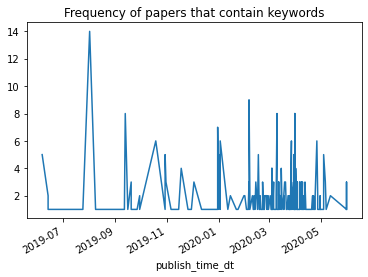

In [67]:
(explode_df
 .groupby(["pid", "publish_time_dt"])
 .size()
 .droplevel("pid")
 .sort_index()
 .plot(title="Frequency of papers that contain keywords")
)

## Matched keyword sentences for papers talking about covid19

In [68]:
explode_df.shape

(489, 7)

In [69]:
explode_df[explode_df.pid.isin(covid_papers)]

,pid,title,publish_time_dt,doi,url,sentence,match_type
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,We examined data on exposures among 10 confirm...,sent-incubation_period_day
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,Our preliminary estimate of the incubation per...,sent-incubation_period_day
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,"Additionally, η accounts for the relative infe...",sent-recovery_rate
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,We find that a small delay in mask adoption (w...,sent-hospitalized_fraction


In [70]:
with pd.option_context('display.min_rows', 99999, 'display.max_columns', None, 'display.max_colwidth', -1):
    display(explode_df)

pid  \
12436  PMC6568391   
12436  PMC6568391   
12484  PMC6595052   
12820  PMC6715637   
12854  PMC6723174   
13123  PMC6816421   
13146  PMC6822455   
13199  PMC6839065   
13204  PMC6844224   
13224  PMC6852973   
13434  PMC6930991   
13434  PMC6930991   
13434  PMC6930991   
13434  PMC6930991   
13434  PMC6930991   
13470  PMC6946222   
13480  PMC6950189   
13480  PMC6950189   
13480  PMC6950189   
13487  PMC6950618   
13514  PMC6962363   
13514  PMC6962363   
13640  PMC7011107   
13640  PMC7011107   
13640  PMC7011107   
13651  PMC7014668   
13654  PMC7014672   
13654  PMC7014672   
13654  PMC7014672   
13654  PMC7014672   
...           ...   
15535  PMC7094046   
16172  PMC7096775   
16172  PMC7096775   
16172  PMC7096775   
17186  PMC7105345   
17747  PMC7107446   
18339  PMC7108749   
18339  PMC7108749   
18339  PMC7108749   
18339  PMC7108749   
18339  PMC7108749   
23512  PMC7124955   
26662  PMC7133586   
26662  PMC7133586   
26662  PMC7133586   
26669  PMC7133601   
27164  PMC7138015   
27164  PMC7138015   
27300  PMC7140598   
27907  PMC7149770   
27907  PMC7149770   
27907  PMC7149770   
29933  PMC7163187   
31295  PMC7169834   
31295  PMC7169834   
33112  PMC7196293   
33112  PMC7196293   
33215  PMC7197734   
33429  PMC7202125   
32564  PMC7186508   

                                                                                                                                                                                                                                           title  \
12436  Health system capacity in Sydney, Australia in the event of a biological attack with smallpox                                                                                                                                               
12436  Health system capacity in Sydney, Australia in the event of a biological attack with smallpox                                                                                                                                               
12484  Stochastic and spatio-temporal analysis of the Middle East Respiratory Syndrome outbreak in South Korea, 2015                                                                                                                               
12820  Specific increase of Fusobacterium in the faecal microbiota of neonatal calves infected with Cryptosporidium parvum                                                                                                                         
12854  Recombinant Chimeric Transmissible Gastroenteritis Virus (TGEV)—Porcine Epidemic Diarrhea Virus (PEDV) Virus Provides Protection against Virulent PEDV                                                                                      
13123  Recombinant vesicular stomatitis virus vector vaccines for WHO blueprint priority pathogens                                                                                                                                                 
13146  Risk of transmission via medical employees and importance of routine infection-prevention policy in a nosocomial outbreak of Middle East respiratory syndrome (MERS): a descriptive analysis from a tertiary care hospital in South Korea   
13199  Epitope‐based peptide vaccine design and target site depiction against Middle East Respiratory Syndrome Coronavirus: an immune-informatics study                                                                                            
13204  Estimation Of Direct Medical Costs Of Middle East Respiratory Syndrome Coronavirus Infection: A Single-Center Retrospective Chart Review Study                                                                                              
13224  Development of indirect enzyme-linked immunosorbent assay for detection of porcine epidemic diarrhea virus specific antibodies (IgG) in serum of naturally infected pigs                                                                    
13434  The characteristics 

In [71]:
temp_merged_meta = explode_df.merge(kw_metadata_df, on='pid')
temp_merged_meta.loc[temp_merged_meta['match_type'] == "sent-incubation_period_day"].loc[~temp_merged_meta.pid.duplicated()].journal.value_counts(dropna=False)

NaN                                                      24
Euro Surveill                                             9
Int J Environ Res Public Health                           8
J Clin Med                                                6
JMIR Public Health Surveill                               5
                                                         ..
Crit Care                                                 1
Cell Discov                                               1
Stroke                                                    1
Journal of the American Medical Directors Association     1
Clin Transl Radiat Oncol                                  1
Name: journal, Length: 148, dtype: int64

In [72]:
temp_merged_meta.pid.duplicated()

0      False
1       True
2      False
3      False
4      False
       ...  
484    False
485    False
486     True
487    False
488    False
Name: pid, Length: 489, dtype: bool

In [73]:
explode_df[explode_df.pid.isin(covid_papers)]

,pid,title,publish_time_dt,doi,url,sentence,match_type
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,We examined data on exposures among 10 confirm...,sent-incubation_period_day
22562,PMC7121484,"Early Transmission Dynamics in Wuhan, China, o...",2020-03-26,10.1056/nejmoa2001316,NaN,Our preliminary estimate of the incubation per...,sent-incubation_period_day
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,"Additionally, η accounts for the relative infe...",sent-recovery_rate
32564,PMC7186508,To mask or not to mask: Modeling the potential...,2020-04-21,10.1016/j.idm.2020.04.001,NaN,We find that a small delay in mask adoption (w...,sent-hospitalized_fraction


In [74]:
now = datetime.now()
print(now)
pl.Path(here("./data/db/final/kaggle/id_model_inputs/", warn=False)).mkdir(parents=True, exist_ok=True)
explode_df.to_csv(here(f"./data/db/final/kaggle/id_model_inputs/03-covid_kw_sentences-{now.strftime('%Y-%m-%d-%H-%M')}.tsv",
                       warn=False),
                  sep="\t",
                  index=False)

2020-06-01 15:04:11.903059
